In [ ]:
!pip install --quiet pyspark==3.3.1 graphframes


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
!gsutil ls


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


gs://dataproc-staging-us-west1-771142642083-0jyqsnk4/
gs://dataproc-temp-us-west1-771142642083-w6vm4doq/
gs://msba-tasmania-svtayade/
gs://venmo-1/


In [ ]:
import os

# Update this path if your VM uses a different Java install
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]


In [ ]:
from pyspark.sql import SparkSession

# Start a local Spark session
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("VenmoAnalysis") \
    .getOrCreate()

print("🚀 Spark version:", spark.version)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/05/31 01:29:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
🚀 Spark version: 3.3.1


In [ ]:
#!pip install --quiet pandas pyarrow


In [ ]:
df = spark.read.parquet("VenmoSample.snappy.parquet")
df.show(3)

+-------+-------+----------------+-------------------+------------+-----------+--------------------+
|  user1|  user2|transaction_type|           datetime| description|is_business|            story_id|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+
|1218774|1528945|         payment|2015-11-27 10:48:19|        Uber|      false|5657c473cd03c9af2...|
|5109483|4782303|         payment|2015-06-17 11:37:04|      Costco|      false|5580f9702b64f70ab...|
|4322148|3392963|         payment|2015-06-19 07:05:31|Sweaty balls|      false|55835ccb1a624b14a...|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+
only showing top 3 rows



In [ ]:
emoji_df = spark.read.csv(
    "Venmo_Emoji_Classification_Dictionary.csv",
    header=True,
    inferSchema=True
)

emoji_df.show(3, truncate=False)


+-----+------+----+--------+--------------+------+-------+
|Event|Travel|Food|Activity|Transportation|People|Utility|
+-----+------+----+--------+--------------+------+-------+
|🇦🇺 |🏔    |🍇  |👾      |🚄            |😀    |⚡      |
|🇫🇷 |⛰     |🍈  |🕴      |🚅            |😃    |💡     |
|🎂   |🌋    |🍉  |🎪      |🚆            |😄    | 🔌    |
+-----+------+----+--------+--------------+------+-------+
only showing top 3 rows



In [ ]:
#pip install openpyxl


In [ ]:
import pandas as pd


In [ ]:
word_pdf = pd.read_excel("Venmo Word Classification Dictonary BAX-423.xlsx", engine='openpyxl')

# Preview
print(word_pdf.shape)
word_pdf.head()

(378, 10)


,People,Food,Event,Activity,Travel,Transportation,Utility,Cash,Illegal/Sarcasm,@dropdown
0,friend,food,birthday,ball,beach,lyft,bill,atm,addiction,NaN
1,friendship,bbq,christmas,boat,place,uber,cable,bank,drug,NaN
2,baby,bean,happy,bar,la,cab,fee,cash,wangs,NaN
3,boy,latte,bday,book,world,bus,electric,money,weed,NaN
4,girl,breakfast,wedding,club,hotel,car,electricity,buck,anal,NaN


In [ ]:

# Reshape wide to long
long_df = word_pdf.melt(var_name='category', value_name='word').dropna()
long_df['word'] = long_df['word'].str.lower()


In [ ]:
import csv

with open("clean_word_long.csv", "w", newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['category', 'word'])  # header
    for row in long_df.itertuples(index=False):
        writer.writerow(row)


In [ ]:
word_long_df = spark.read.option("header", True).csv("clean_word_long.csv")
from pyspark.sql.functions import lower, col
word_long_df = word_long_df.withColumn("word", lower(col("word")))


In [ ]:
#!pip install emoji
import emoji
import re


In [ ]:
import re

emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map
    u"\U0001F1E0-\U0001F1FF"  # flags
    u"\U00002700-\U000027BF"
    u"\U0001F900-\U0001F9FF"
    u"\U00002600-\U000026FF"
    "]+", flags=re.UNICODE)



In [ ]:
df.columns


['user1',
 'user2',
 'transaction_type',
 'datetime',
 'description',
 'is_business',
 'story_id']

In [ ]:
#def classify_message(text):
 #   if text is None or text.strip() == "":
  #      return "other"
   # has_emoji = bool(emoji_pattern.search(text))
    #has_text = bool(re.sub(emoji_pattern, '', text).strip())
    #if has_emoji and has_text:
     #   return "both"
    #elif has_emoji:
     #   return "emoji-only"
    #elif has_text:
     #   return "text-only"
    #else:
     #   return "other"

# Register as UDF
#classify_udf = udf(classify_message, StringType())

# Apply to the 'description' column
#df = df.withColumn("msg_type", classify_udf(df["description"]))

# Optional: Preview result
#df.select("description", "msg_type").show(10, truncate=False)


In [ ]:
from pyspark.sql.functions import col, lower, udf
from pyspark.sql.types import StringType
import re
import emoji

# 1. Fill null descriptions
df = df.fillna({"description": ""})

# 2. Lowercase everything
df = df.withColumn("clean_desc", lower(col("description")))

# 3. Define UDF to detect message type
def get_msg_type(text):
    if not text.strip():
        return "empty"
    has_emoji = any(char in emoji.EMOJI_DATA for char in text)
    has_text = bool(re.search(r'[a-zA-Z]', text))
    if has_emoji and not has_text:
        return "emoji-only"
    elif has_text and not has_emoji:
        return "text-only"
    elif has_emoji and has_text:
        return "mixed"
    else:
        return "other"

msg_type_udf = udf(get_msg_type, StringType())
df = df.withColumn("msg_type", msg_type_udf(col("clean_desc")))

# Optional: sanity check
df.groupBy("msg_type").count().show()


+----------+-------+
|  msg_type|  count|
+----------+-------+
|     mixed| 716768|
|emoji-only|1858740|
|     other| 104951|
| text-only|4432497|
|     empty|    181|
+----------+-------+



In [ ]:
from pyspark.sql.functions import col

emoji_only_count = df.filter(col("msg_type") == "emoji-only").count()
total_count = df.count()

print(f"✅ Corrected percentage of emoji-only messages: {round(emoji_only_count / total_count * 100, 2)}%")



✅ Corrected percentage of emoji-only messages: 26.13%


In [ ]:
#!pip install regex

In [ ]:
from pyspark.sql.functions import explode
import regex
from pyspark.sql.types import ArrayType

# 1. Extract emoji safely (multi-codepoint aware)
emoji_pattern = regex.compile(r'\X', flags=regex.UNICODE)

def extract_emojis(text):
    return [char for char in emoji_pattern.findall(text) if regex.match(r'\p{Emoji}', char)]

extract_emojis_udf = udf(extract_emojis, ArrayType(StringType()))



In [ ]:
# 2. Apply to emoji-only + mixed messages
emoji_df = df.filter(df.msg_type.isin("emoji-only", "mixed"))
emoji_df = emoji_df.withColumn("emojis", extract_emojis_udf("clean_desc"))

# 3. Explode to one emoji per row
exploded = emoji_df.select(explode("emojis").alias("emoji"))

# 4. Count top 5
top_5_emojis = exploded.groupBy("emoji").count().orderBy("count", ascending=False)
top_5_emojis.show(5, truncate=False)


+-----+------+
|emoji|count |
+-----+------+
|🍕   |215031|
|🍻   |145229|
|💸   |124726|
|🍷   |111157|
|🎉   |94321 |
+-----+------+
only showing top 5 rows



In [ ]:
emoji_df.head()

Row(user1=469894, user2=1333620, transaction_type='charge', datetime=datetime.datetime(2016, 6, 3, 23, 34, 13), description='🎥', is_business=False, story_id='5751b185cd03c9af224c0d17', clean_desc='🎥', msg_type='emoji-only', emojis=['🎥'])

In [ ]:
from pyspark.sql.functions import col, lit, explode, array, struct

# Load the wide-format emoji CSV
emoji_df_wide = spark.read.option("header", True).csv("Venmo_Emoji_Classification_Dictionary.csv")

# Manually reshape each category column into (emoji, category) structure
category_columns = emoji_df_wide.columns

# Create an array of structs [(emoji, category), ...] and explode
reshaped = emoji_df_wide.select(
    explode(
        array([
            struct(col(c).alias("emoji"), lit(c).alias("category")) for c in category_columns
        ])
    ).alias("emoji_struct")
).select("emoji_struct.emoji", "emoji_struct.category").where(col("emoji_struct.emoji").isNotNull())

# Preview
reshaped.show(5, truncate=False)


+-----+--------------+
|emoji|category      |
+-----+--------------+
|🇦🇺 |Event         |
|🏔   |Travel        |
|🍇   |Food          |
|👾   |Activity      |
|🚄   |Transportation|
+-----+--------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import explode, col, desc

# Step 1: Start from emoji_df (with msg_type filtered)
emoji_df = df.filter(df.msg_type.isin("emoji-only", "mixed"))
emoji_df = emoji_df.withColumn("emojis", extract_emojis_udf(col("clean_desc")))

# Step 2: Explode emojis into rows
exploded_df = emoji_df.select("story_id", explode("emojis").alias("emoji"))

# Step 3: Join with reshaped emoji dictionary
emoji_with_category = exploded_df.join(
    reshaped,
    on="emoji",
    how="left"
)

# Step 4: Group by category and count
top_categories = emoji_with_category.groupBy("category").count().orderBy(desc("count"))

# Step 5: Show top 3
top_categories.show(3, truncate=False)



+--------+-------+
|category|count  |
+--------+-------+
|null    |2001776|
|Food    |1709463|
|People  |787222 |
+--------+-------+
only showing top 3 rows



In [ ]:
#to visit the above question again

In [ ]:
#missing = exploded_df.join(reshaped, on="emoji", how="left_anti")
#print("❌ Unmatched unique emojis:", missing.select("emoji").distinct().count())
#missing.select("emoji").distinct().show(5, truncate=False)


In [ ]:
# PROFLING

In [ ]:
exploded_df.show(10, truncate=False)

+------------------------+-----+
|story_id                |emoji|
+------------------------+-----+
|5751b185cd03c9af224c0d17|🎥   |
|574b178ecd03c9af22cf67f4|⚡    |
|5689c6bdcd03c9af224a8cbc|👠   |
|561080a1cd03c9af226311e2|🍺   |
|577e69e723e064eac070091a|⛽    |
|56cd03e4cd03c9af225aabfe|🔮   |
|570866c2cd03c9af223706e1|🔴   |
|5572010807f81c2c9e79d5d2|💁🏻 |
|5572010807f81c2c9e79d5d2|🍕   |
|56ac27b9cd03c9af224fe75d|🎉   |
+------------------------+-----+
only showing top 10 rows



In [ ]:
#emoji_cat_df.show(10, truncate=False)

In [ ]:
from pyspark.sql.functions import count, row_number
from pyspark.sql.window import Window

# Join emojis to categories
emoji_with_cat = exploded_df.join(reshaped, on="emoji", how="left")

# Count emoji categories per transaction
emoji_cat_freq = emoji_with_cat.groupBy("story_id", "category").agg(count("*").alias("count"))

# Rank categories by count (use majority vote per story_id)
w = Window.partitionBy("story_id").orderBy(col("count").desc())

emoji_cat_df = emoji_cat_freq.withColumn("rank", row_number().over(w)) \
                             .filter(col("rank") == 1) \
                             .select("story_id", col("category").alias("emoji_category"))


In [ ]:
from pyspark.sql.functions import lower, split, explode, first

text_words_df = df.select("story_id", explode(split(lower(col("description")), "\s+")).alias("word"))

word_cat_df = text_words_df.join(word_long_df, on="word", how="left") \
    .groupBy("story_id") \
    .agg(first("category", ignorenulls=True).alias("word_category"))


In [ ]:
from pyspark.sql.functions import coalesce

category_df = emoji_cat_df.join(word_cat_df, on="story_id", how="outer") \
    .withColumn("category", coalesce("emoji_category", "word_category"))


In [ ]:
df_with_cat = df.join(category_df.select("story_id", "category"), on="story_id", how="left")
df_cat = df_with_cat.filter(col("category").isNotNull())


In [ ]:
from pyspark.sql.functions import count

# Per user per category
cat_counts = df_cat.groupBy("user1", "category").agg(count("*").alias("cat_count"))

# Total transactions per user
user_total = df_cat.groupBy("user1").agg(count("*").alias("total_txns"))

# Compute share
from pyspark.sql.functions import col

static_profile = cat_counts.join(user_total, on="user1") \
    .withColumn("category_share", col("cat_count") / col("total_txns"))


In [ ]:
static_profile.orderBy("user1", "category_share", ascending=False).show(2, truncate=False)


25/05/30 18:49:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 18:49:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/30 18:49:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 18:49:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 18:49:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 18:49:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 18:49:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 18:49:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/30 18:49:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 18:49:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 18:49:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 18:49:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+--------+--------+---------+----------+--------------+
|user1   |category|cat_count|total_txns|category_share|
+--------+--------+---------+----------+--------------+
|16013547|Event   |1        |1         |1.0           |
|15953299|Activity|1        |1         |1.0           |
+--------+--------+---------+----------+--------------+
only showing top 2 rows



In [ ]:
print("Total transactions:", df.count())
print("Categorized transactions:", df_with_cat.filter(col("category").isNotNull()).count())


Total transactions: 7113137


Categorized transactions: 4115587


In [ ]:
df_cat.groupBy("user1").agg(count("*").alias("n_cat_txns")).orderBy("n_cat_txns", ascending=False).show(20)


25/05/30 19:07:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:07:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:07:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:07:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-------+----------+
|  user1|n_cat_txns|
+-------+----------+
| 820531|      1213|
|4188588|       252|
| 590439|       161|
| 626770|       151|
|1751344|        99|
|3664982|        87|
| 510480|        79|
| 390378|        70|
| 400321|        68|
| 254334|        65|
| 219036|        63|
| 148281|        62|
| 277650|        61|
| 161654|        61|
|4637807|        60|
| 648130|        60|
| 367855|        57|
| 402321|        55|
| 202214|        53|
| 874472|        53|
+-------+----------+
only showing top 20 rows



In [ ]:
static_profile.filter(col("total_txns") > 20) \
    .orderBy("user1", "category_share", ascending=False) \
    .show(5, truncate=False)


25/05/30 19:15:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:15:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:15:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/30 19:16:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/30 19:19:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:20:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/30 19:20:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:21:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/30 19:21:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/30 19:24:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/30 19:24:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:24:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:24:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:24:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:24:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/30 19:24:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:24:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:24:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:24:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:24:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:24:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/30 19:24:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/30 19:24:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:24:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:24:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/30 19:24:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:24:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:24:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:24:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/30 19:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:26:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:26:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:26:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:26:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/30 19:26:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/30 19:26:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:26:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/30 19:26:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+--------+--------------+---------+----------+--------------+
|user1   |category      |cat_count|total_txns|category_share|
+--------+--------------+---------+----------+--------------+
|10305628|Food          |11       |25        |0.44          |
|10305628|Activity      |10       |25        |0.4           |
|10305628|Transportation|2        |25        |0.08          |
|10305628|Travel        |1        |25        |0.04          |
|10305628|Event         |1        |25        |0.04          |
+--------+--------------+---------+----------+--------------+
only showing top 5 rows



In [ ]:
#dynamic profile


In [ ]:
from pyspark.sql.functions import min, max, datediff, col

user_lifetime = df_cat.groupBy("user1").agg(
    min("datetime").alias("start_date"),
    max("datetime").alias("end_date")
).withColumn("days_active", datediff("end_date", "start_date"))

valid_users = user_lifetime.filter(col("days_active") >= 365).select("user1")
df_1y = df_cat.join(valid_users, on="user1", how="inner")


In [ ]:
from pyspark.sql.functions import floor

user_start = df_1y.groupBy("user1").agg(min("datetime").alias("first_txn"))
df_1y = df_1y.join(user_start, on="user1")
df_1y = df_1y.withColumn("month_since_start", floor(datediff("datetime", "first_txn") / 30))
df_1y = df_1y.filter((col("month_since_start") >= 0) & (col("month_since_start") <= 12))


In [ ]:
user_month_cat = df_1y.groupBy("user1", "month_since_start", "category") \
    .agg(count("*").alias("txn_count"))

user_month_total = df_1y.groupBy("user1", "month_since_start") \
    .agg(count("*").alias("total_txns"))

user_month_profile = user_month_cat.join(user_month_total, ["user1", "month_since_start"]) \
    .withColumn("category_share", col("txn_count") / col("total_txns"))


In [ ]:
from pyspark.sql.functions import avg, stddev

agg_profile = user_month_profile.groupBy("month_since_start", "category") \
    .agg(
        avg("category_share").alias("avg_share"),
        stddev("category_share").alias("std_share")
    )


In [ ]:
agg_pd = agg_profile.toPandas()


25/05/31 01:47:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 01:47:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/31 01:47:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/31 01:47:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/31 01:47:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 01:47:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/31 01:47:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 01:47:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 01:47:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 01:47:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 01:47:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 01:47:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 01:47:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 01:47:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


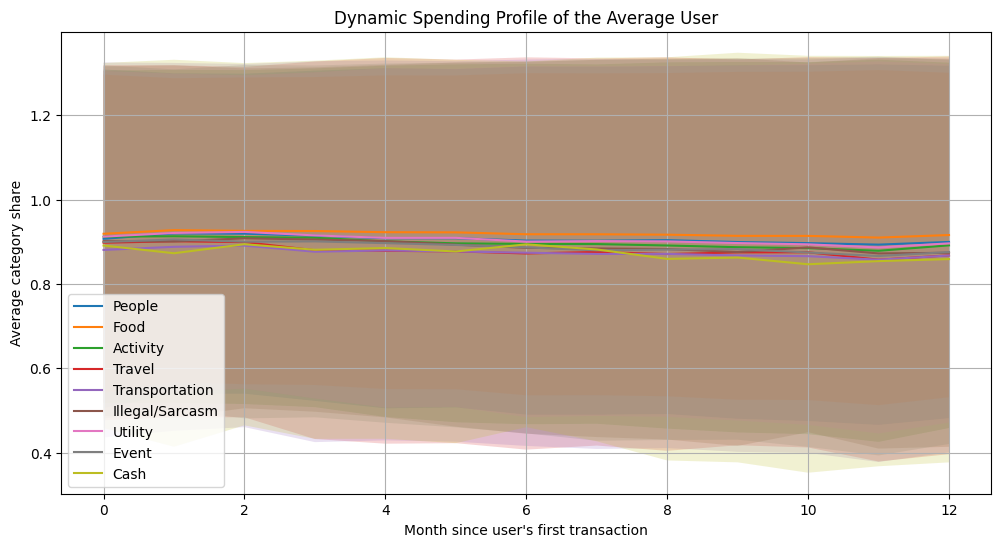

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for cat in agg_pd['category'].unique():
    subset = agg_pd[agg_pd['category'] == cat].sort_values("month_since_start")
    plt.plot(subset['month_since_start'], subset['avg_share'], label=cat)
    plt.fill_between(
        subset['month_since_start'],
        subset['avg_share'] - 2 * subset['std_share'],
        subset['avg_share'] + 2 * subset['std_share'],
        alpha=0.2
    )

plt.xlabel("Month since user's first transaction")
plt.ylabel("Average category share")
plt.title("Dynamic Spending Profile of the Average User")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# embedding part

In [ ]:
!pip install transformers accelerate sentencepiece --quiet


In [ ]:
# Sample Spark to Pandas conversion for embedding
sampled_df = df.where("clean_desc IS NOT NULL").limit(50000)
texts = sampled_df.select("clean_desc").rdd.flatMap(lambda x: x).collect()


In [ ]:
from huggingface_hub import login

# Replace this with your real token
login("enter_your_hugging_face_token")


In [ ]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
import os
import gc

model_id = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_id)

# ✅ Fix: add pad token if missing
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

model = AutoModel.from_pretrained(model_id, torch_dtype="auto", device_map="auto")

# Resize model embedding layer to include [PAD]
model.resize_token_embeddings(len(tokenizer))
model.eval()

# Set your list of texts
# Example: texts = ["sentence 1", "sentence 2", ..., "sentence 50000"]
# Assume `texts` is already defined
batch_size = 1052
save_dir = "embedding_chunks"
os.makedirs(save_dir, exist_ok=True)

for i in range(0, len(texts), batch_size):
    batch = texts[i:i+batch_size]
    try:
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            last_hidden_state = outputs.hidden_states[-1]  # shape: (batch_size, seq_len, hidden_dim)

        # Compute mean embedding (ignoring padded tokens)
        mask = inputs['attention_mask'].unsqueeze(-1)  # shape: (batch_size, seq_len, 1)
        sum_hidden = torch.sum(last_hidden_state * mask, dim=1)
        count_tokens = torch.sum(mask, dim=1)
        mean_embeddings = (sum_hidden / count_tokens).cpu().float().numpy()

        # Save chunk
        np.save(os.path.join(save_dir, f"embedding_chunk_{i//batch_size}.npy"), mean_embeddings)

        # Clean up
        del inputs, outputs, last_hidden_state, mask, sum_hidden, count_tokens
        torch.cuda.empty_cache()
        gc.collect()

        print(f"✅ Saved chunk {i//batch_size} with {len(batch)} items")

    except Exception as e:
        print(f"❌ Error at batch {i}: {e}")


✅ Saved chunk 0 with 1052 items
✅ Saved chunk 1 with 1052 items
✅ Saved chunk 2 with 1052 items
✅ Saved chunk 3 with 1052 items
✅ Saved chunk 4 with 1052 items
✅ Saved chunk 5 with 1052 items
✅ Saved chunk 6 with 1052 items
✅ Saved chunk 7 with 1052 items
✅ Saved chunk 8 with 1052 items
✅ Saved chunk 9 with 1052 items
✅ Saved chunk 10 with 1052 items
✅ Saved chunk 11 with 1052 items
✅ Saved chunk 12 with 1052 items
✅ Saved chunk 13 with 1052 items
✅ Saved chunk 14 with 1052 items
✅ Saved chunk 15 with 1052 items
✅ Saved chunk 16 with 1052 items
✅ Saved chunk 17 with 1052 items
✅ Saved chunk 18 with 1052 items
✅ Saved chunk 19 with 1052 items
✅ Saved chunk 20 with 1052 items
✅ Saved chunk 21 with 1052 items
✅ Saved chunk 22 with 1052 items
✅ Saved chunk 23 with 1052 items
✅ Saved chunk 24 with 1052 items
✅ Saved chunk 25 with 1052 items
✅ Saved chunk 26 with 1052 items
✅ Saved chunk 27 with 1052 items
✅ Saved chunk 28 with 1052 items
✅ Saved chunk 29 with 1052 items
✅ Saved chunk 30 wit

In [ ]:
import numpy as np
import os
from glob import glob

# Directory where chunks are saved
save_dir = "embedding_chunks"

# Get sorted list of all chunk files
chunk_files = sorted(glob(os.path.join(save_dir, "embedding_chunk_*.npy")))

# Load and stack all embeddings
all_embeddings = np.vstack([np.load(chunk) for chunk in chunk_files])

# Save as a single .npy file
np.save("llama_embeddings.npy", all_embeddings)

print(f"✅ Saved combined embeddings: shape = {all_embeddings.shape}")



✅ Saved combined embeddings: shape = (55120, 384)


In [ ]:

# Save corresponding texts
texts_df = pd.DataFrame(texts, columns=["text"])
texts_df.to_csv("texts_llama.csv", index=False)

print("✅ Embeddings and texts saved successfully.")


✅ Embeddings and texts saved successfully.


In [ ]:
import numpy as np
import pandas as pd

# Load embeddings and texts
embeddings = np.load("llama_embeddings.npy")
texts = pd.read_csv("texts_llama.csv")["text"].tolist()


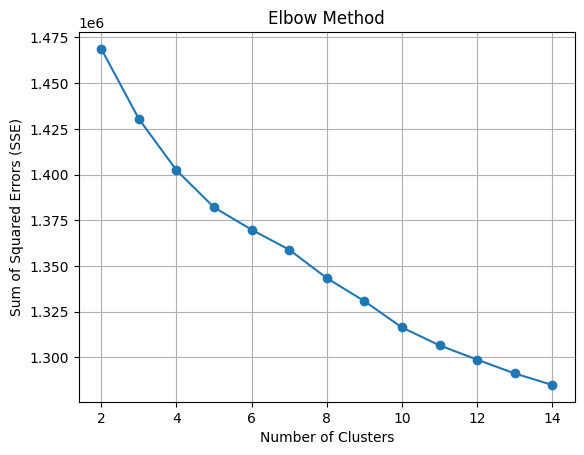

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
k_values = range(2, 15)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(embeddings)
    sse.append(kmeans.inertia_)

plt.plot(k_values, sse, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("Elbow Method")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.cluster import KMeans

k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)


In [ ]:
import pandas as pd
df_cluster = pd.DataFrame({
    "text": texts,
    "cluster": cluster_labels
})



In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

for i in range(10):  # assuming k=6
    cluster_indices = df_cluster[df_cluster["cluster"] == i].index
    cluster_texts = df_cluster.loc[cluster_indices, "text"].tolist()
    cluster_vectors = embeddings[cluster_indices]

    centroid = kmeans.cluster_centers_[i].reshape(1, -1)
    sims = cosine_similarity(centroid, cluster_vectors).flatten()
    top10_idx = np.argsort(sims)[-10:][::-1]

    print(f"\n🟦 Cluster {i}: Top 10 Representative Messages")
    for idx in top10_idx:
        print(f"  - {cluster_texts[idx]}")



🟦 Cluster 0: Top 10 Representative Messages
  - kickball
  - 💵
  - sushi!
  - 👉😎👉
  - deposit minus utilities!
  - wings
  - for thanks
  - shock value
  - stuff for the hookah
  - costco

🟦 Cluster 1: Top 10 Representative Messages
  - champagne life
  - uber
  - 🚚🚛🚚🚛
  - uber
  - uber
  - uber
  - ❤️
  - 250 🏠💸/50 ⛽
  - 📓
  - 💩

🟦 Cluster 2: Top 10 Representative Messages
  - 🎥
  - 💃🏻❤️🔥💁🏻
  - ⚡🔌💡💸
  - 🏰🌠🎠🎆🚗
  - 🍺
  - 🇺🇸
  - 👳🏾
  - 🅿
  - 🍪🍪🍪
  - 🎯

🟦 Cluster 3: Top 10 Representative Messages
  - investment into the future of an amazing record store
  - for ice cream!
  - 🏠💸
  - ⛽ & 📺💸
  - w
  - misc
  - 👵
  - 🖕
  - bills
  - bills

🟦 Cluster 4: Top 10 Representative Messages
  - for bills  bills  bills
  - parking
  - hotel
  - 🍕
  - oj💂🏿
  - 💧➕💥
  - 👖
  - arby's
  - meeting the love of my life
  - friendship maintenance fee

🟦 Cluster 5: Top 10 Representative Messages
  - bbq
  - the stegz
  - 💵💵💸
  - grad tacos x 3
  - hockey ticket
  - china
  - 💸
  - 👕
  - gingerale
  - i don't 

In [ ]:
df_cat.columns


['story_id',
 'user1',
 'user2',
 'transaction_type',
 'datetime',
 'description',
 'is_business',
 'clean_desc',
 'msg_type',
 'category']

In [ ]:
# First ensure df_cluster is a pandas DataFrame and has 'clean_desc'
# We'll collect only the matching clean_desc values from df_cat
matched_descs = df_cluster["clean_desc"].unique().tolist()

# Create a smaller filtered Spark DataFrame
df_cat_filtered = df_cat.filter(df_cat.clean_desc.isin(matched_descs))

# Then convert to pandas
df_cat_pd = df_cat_filtered.select("clean_desc", "category").toPandas()


25/05/31 00:06:57 WARN TaskMemoryManager: Failed to allocate a page (67108864 bytes), try again.
25/05/31 00:06:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/31 00:07:39 WARN DAGScheduler: Broadcasting large task binary with size 1740.3 KiB


In [ ]:
df_merged = df_cluster.merge(df_cat_pd, on="clean_desc", how="inner")

from sklearn.metrics import adjusted_rand_score
ari_score = adjusted_rand_score(df_merged["category"], df_merged["cluster"])
print("🔁 Adjusted Rand Index:", ari_score)


🔁 Adjusted Rand Index: -0.0016197266043250825


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

for i in range(6):
    cluster_texts = df[df["cluster"] == i]["text"].dropna().tolist()

    if len(cluster_texts) == 0:
        print(f"⚠️ Cluster {i} has no valid text entries.")
        continue

    vectorizer = TfidfVectorizer(max_features=100, stop_words="english")
    X = vectorizer.fit_transform(cluster_texts)

    tfidf_scores = X.sum(axis=0).A1
    keywords = np.array(vectorizer.get_feature_names_out())[np.argsort(tfidf_scores)[::-1][:10]]

    print(f"\n🔖 Cluster {i} Keywords: {', '.join(keywords)}")



🔖 Cluster 0 Keywords: food, pizza, rent, good, uber, stuff, fantasy, bills, gas, thanks

🔖 Cluster 1 Keywords: uber, rent, food, dinner, fantasy, taxi, love, parking, life, za

🔖 Cluster 2 Keywords: food, rent, uber, stuff, gas, thanks, dinner, good, bills, pizza

🔖 Cluster 3 Keywords: food, uber, bills, pizza, fantasy, thank, thanks, rent, stuff, gas

🔖 Cluster 4 Keywords: food, rent, uber, gas, thanks, stuff, vegas, love, night, thank

🔖 Cluster 5 Keywords: food, rent, gas, uber, thanks, bills, stuff, dinner, good, night


In [ ]:
cluster_names = {
    0: "Essentials & Meals",
    1: "Shared Expenses & Rent",
    2: "Dining & Drinks",
    3: "Friends & Social Life",
    4: "Bills & Utilities",
    5: "Lifestyle & Fun"
}

df["cluster_name"] = df["cluster"].map(cluster_names)


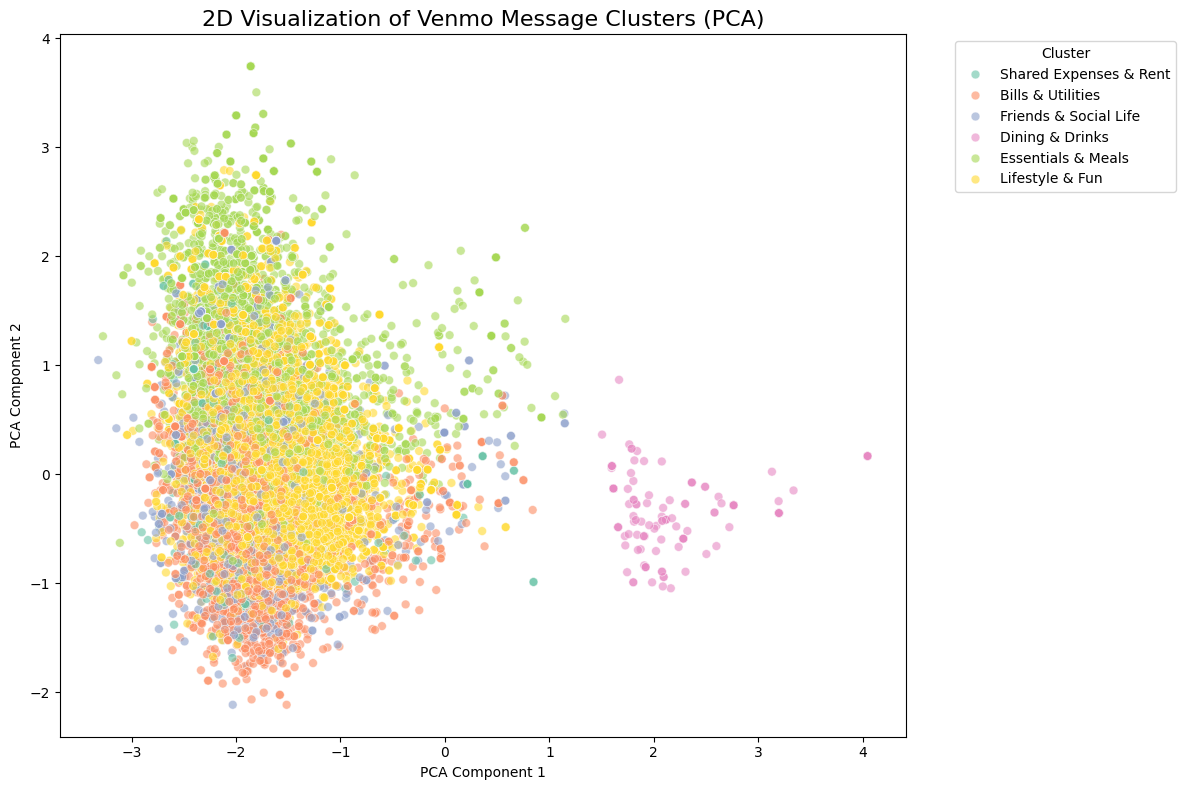

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Perform PCA for 2D visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings[:len(df)])  # Match the length of df (49999)

# Add PCA results to DataFrame
df["pca_1"] = reduced_embeddings[:, 0]
df["pca_2"] = reduced_embeddings[:, 1]

# Plot clusters in 2D
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x="pca_1",
    y="pca_2",
    hue="cluster_name",
    palette="Set2",
    alpha=0.6,
    s=40
)
plt.title("2D Visualization of Venmo Message Clusters (PCA)", fontsize=16)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
#saving data files for part 3

In [ ]:
from pyspark.sql.functions import col

# Convert datetime to string to avoid pandas datetime casting issues
df_text = (
    df_cat.withColumn("datetime_str", col("datetime").cast("string"))
          .select("story_id", "user1", "datetime_str", "clean_desc", "category")
          .toPandas()
)

# Rename column back to 'datetime' for consistency
df_text.rename(columns={"datetime_str": "datetime"}, inplace=True)

# Save to parquet
df_text.to_parquet("venmo_text_part1.parquet", index=False)

df_text = df_cat.select(
    "story_id", "user1", F.col("datetime").cast("string").alias("datetime"), "clean_desc", "category"
)

df_text.write.mode("overwrite").parquet("venmo_text_part1.parquet")



Exception in thread "refresh progress" java.lang.OutOfMemoryError: Java heap space
	at scala.Option.map(Option.scala:230)
	at org.apache.spark.status.AppStatusStore.activeStages(AppStatusStore.scala:164)
	at org.apache.spark.ui.ConsoleProgressBar.org$apache$spark$ui$ConsoleProgressBar$$refresh(ConsoleProgressBar.scala:64)
	at org.apache.spark.ui.ConsoleProgressBar$$anon$1.run(ConsoleProgressBar.scala:52)
	at java.base/java.util.TimerThread.mainLoop(Timer.java:556)
	at java.base/java.util.TimerThread.run(Timer.java:506)


Py4JJavaError: An error occurred while calling o434.collectToPython.
: java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.sql.execution.SparkPlan$$anon$1._next(SparkPlan.scala:391)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.getNext(SparkPlan.scala:402)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.getNext(SparkPlan.scala:388)
	at org.apache.spark.util.NextIterator.hasNext(NextIterator.scala:73)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.util.NextIterator.foreach(NextIterator.scala:21)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$1(SparkPlan.scala:425)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$1$adapted(SparkPlan.scala:424)
	at org.apache.spark.sql.execution.SparkPlan$$Lambda$3766/0x00000008415cc040.apply(Unknown Source)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:424)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:345)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec$$Lambda$3316/0x0000000841465040.apply(Unknown Source)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:373)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:345)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3688)
	at org.apache.spark.sql.Dataset$$Lambda$3943/0x000000084166c040.apply(Unknown Source)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:3858)
	at org.apache.spark.sql.Dataset$$Lambda$2525/0x00000008410e8440.apply(Unknown Source)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:510)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3856)
	at org.apache.spark.sql.Dataset$$Lambda$2216/0x0000000840f92c40.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:109)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$2224/0x0000000840f98040.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$2217/0x0000000840f93840.apply(Unknown Source)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)


In [ ]:
df_merged.to_parquet("venmo_clustered_with_cat.parquet", index=False)


In [ ]:
# Save category trend stats (optional but useful for plots)
agg_pd.to_parquet("venmo_category_trends.parquet", index=False)


In [ ]:
# Save dynamic profile per user-month-category
user_month_profile_pd = user_month_profile.toPandas()
user_month_profile_pd.to_parquet("venmo_dynamic_profile.parquet", index=False)



25/05/31 00:50:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:50:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:50:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:50:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:50:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:51:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:51:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/31 00:51:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:51:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:51:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:51:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/31 00:53:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:53:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:53:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:53:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:53:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:54:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/31 00:54:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:54:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:54:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:54:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:54:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/31 00:55:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/31 00:55:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/31 00:56:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/31 00:56:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/31 00:57:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:57:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:57:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/31 00:57:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:57:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:57:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/31 00:57:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:57:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:57:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/31 00:57:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:57:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:57:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/31 00:57:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/31 00:59:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:59:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:59:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/31 00:59:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/31 00:59:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/31 00:59:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:59:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:59:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/31 00:59:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/31 00:59:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:59:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:59:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:59:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:59:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:59:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/05/31 00:59:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:59:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:59:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:59:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:59:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:59:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:59:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:59:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 00:59:28 WARN RowBasedKeyValueBatch: Calling spill() on

NameError: name 'agg_pd' is not defined

In [ ]:
#predictive analytics

In [ ]:
df_cat.columns

['story_id',
 'user1',
 'user2',
 'transaction_type',
 'datetime',
 'description',
 'is_business',
 'clean_desc',
 'msg_type',
 'category']

In [ ]:
#Create the dependent variable Y, defined as the total number of transactions a user makes during their first 12 months on Venmo

In [ ]:
from pyspark.sql.functions import col, min, datediff, count, floor
from pyspark.sql.window import Window

# Step 1: Prepare lifetime data
df_lifetime = df_cat.withColumn("datetime", col("datetime").cast("timestamp"))

user_min_date = df_lifetime.groupBy("user1").agg(min("datetime").alias("start_date"))
df_lifetime = df_lifetime.join(user_min_date, on="user1")
df_lifetime = df_lifetime.withColumn("lifetime_month", floor(datediff("datetime", "start_date") / 30))
df_lifetime = df_lifetime.filter((col("lifetime_month") >= 0) & (col("lifetime_month") <= 12))

# ✅ Step 2: Sample 1% of the data for faster processing
df_lifetime_sampled = df_lifetime.sample(withReplacement=False, fraction=0.01, seed=42)


In [ ]:
from pyspark.sql.functions import count

df_target_Y = (
    df_lifetime_sampled
    .groupBy("user1")
    .agg(count("*").alias("Y_total_txn_12mo"))
)


In [ ]:
from pyspark.sql.functions import dayofmonth, max, round

# Add day of month
df_lifetime_sampled = df_lifetime_sampled.withColumn("day", dayofmonth("datetime"))

# Group by user and lifetime month
rf = (
    df_lifetime_sampled
    .groupBy("user1", "lifetime_month")
    .agg(
        max("day").alias("last_day"),
        count("*").alias("txn_count")
    )
)

# Compute RF metrics
rf = rf.withColumn("recency", 30 - col("last_day"))
rf = rf.withColumn("frequency", round(30 / col("txn_count"), 2))


In [ ]:
# Join RF with target Y
rf_target = rf.join(df_target_Y, on="user1", how="inner")
rf_target = rf_target.withColumnRenamed("Y_total_txn_12mo", "Y")

# Select relevant features
rf_target = rf_target.select("user1", "lifetime_month", "recency", "frequency", "Y")


In [ ]:
rf_target_pd = rf_target.toPandas()

25/05/31 03:09:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 03:09:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 03:09:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 03:10:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 03:10:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 03:10:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 03:11:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 03:12:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 03:12:39 WARN RowBasedKeyValueBatch: Calling spill() on

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Make sure we have clean data
rf_target_pd = rf_target_pd.dropna(subset=["recency", "frequency", "Y", "lifetime_month"])

mse_results = []

for m in range(13):  # Lifetime month 0 to 12
    data_m = rf_target_pd[rf_target_pd["lifetime_month"] <= m]

    if len(data_m) < 20:
        continue

    X = data_m[["recency", "frequency"]]
    y = data_m["Y"]

    model = LinearRegression()
    model.fit(X, y)

    preds = model.predict(X)
    mse = mean_squared_error(y, preds)

    mse_results.append((m, mse))
    print(f"Month {m}: MSE = {mse:.2f}")



25/05/31 03:29:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
Month 0: MSE = 0.01
Month 1: MSE = 0.01
Month 2: MSE = 0.01
Month 3: MSE = 0.02
Month 4: MSE = 0.02
Month 5: MSE = 0.02
Month 6: MSE = 0.02
Month 7: MSE = 0.02
Month 8: MSE = 0.02
Month 9: MSE = 0.02
Month 10: MSE = 0.02
Month 11: MSE = 0.02
Month 12: MSE = 0.02


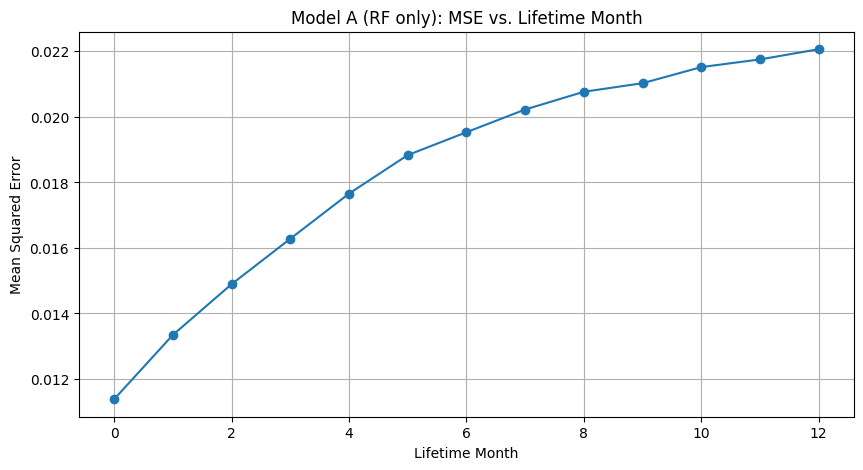

25/05/31 03:29:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 03:29:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 03:29:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 03:29:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [ ]:
# Convert results to DataFrame
mse_df = pd.DataFrame(mse_results, columns=["month", "mse"])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(mse_df["month"], mse_df["mse"], marker='o')
plt.title("Model A (RF only): MSE vs. Lifetime Month")
plt.xlabel("Lifetime Month")
plt.ylabel("Mean Squared Error")
plt.grid(True)
plt.show()


In [ ]:
#ModelB

In [ ]:
# Load the Venmo transaction parquet file
df_behavior = spark.read.parquet("venmo_dynamic_profile.parquet")

# Optional: Check the schema and a sample
df_behavior.printSchema()
df_behavior.show(5)


root
 |-- user1: integer (nullable = true)
 |-- month_since_start: long (nullable = true)
 |-- category: string (nullable = true)
 |-- txn_count: long (nullable = true)
 |-- total_txns: long (nullable = true)
 |-- category_share: double (nullable = true)

+-----+-----------------+--------+---------+----------+--------------+
|user1|month_since_start|category|txn_count|total_txns|category_share|
+-----+-----------------+--------+---------+----------+--------------+
|   10|                3|    Food|        1|         2|           0.5|
|   10|                3|  People|        1|         2|           0.5|
|   11|                0|    Food|        1|         1|           1.0|
|   13|               12|  People|        1|         1|           1.0|
|   19|                0|Activity|        1|         1|           1.0|
+-----+-----------------+--------+---------+----------+--------------+
only showing top 5 rows



In [ ]:
from pyspark.sql import functions as F

df_behavior_wide = (
    df_behavior
    .groupBy("user1", "month_since_start")
    .pivot("category")
    .agg(F.first("category_share"))
    .fillna(0)
)

df_behavior_wide.show(5)


+------+-----------------+------------------+----+-----+------------------+---------------+------+--------------+------+-------+
| user1|month_since_start|          Activity|Cash|Event|              Food|Illegal/Sarcasm|People|Transportation|Travel|Utility|
+------+-----------------+------------------+----+-----+------------------+---------------+------+--------------+------+-------+
|277306|                7|               0.0| 0.0|  0.0|               1.0|            0.0|   0.0|           0.0|   0.0|    0.0|
|331321|                8|               0.0| 0.0|  0.0|               0.5|            0.0|   0.0|           0.5|   0.0|    0.0|
|441899|               10|0.3333333333333333| 0.0|  0.0|0.6666666666666666|            0.0|   0.0|           0.0|   0.0|    0.0|
|493396|                3|               0.0| 0.0|  0.0|               1.0|            0.0|   0.0|           0.0|   0.0|    0.0|
|338421|                0|               0.0| 0.0|  0.0|               0.0|            0.0|   0.0

In [ ]:
from pyspark.sql.functions import col, min, max as spark_max, count, floor, datediff
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# -----------------------------
# Step 1: Prepare df_lifetime
# -----------------------------
df_lifetime = df_cat.withColumn("datetime", col("datetime").cast("timestamp"))

# Compute start date per user
user_min_date = df_lifetime.groupBy("user1").agg(min("datetime").alias("start_date"))

# Add lifetime month = month since user's first transaction
df_lifetime = df_lifetime.join(user_min_date, on="user1")
df_lifetime = df_lifetime.withColumn("lifetime_month", floor(datediff("datetime", "start_date") / 30))

# Filter to valid 0–12 month window
df_lifetime = df_lifetime.filter((col("lifetime_month") >= 0) & (col("lifetime_month") <= 12))

# -----------------------------


In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import sum as spark_sum

# For each user and lifetime_month, count how many future transactions in next 12 months
future_window = Window.partitionBy("user1").orderBy("lifetime_month").rowsBetween(1, 12)

df_lifetime = df_lifetime.withColumn("txn_count", F.lit(1))  # 1 per transaction
df_lifetime = df_lifetime.withColumn("Y", spark_sum("txn_count").over(future_window))

# Now re-aggregate again (like earlier)
df_monthly = df_lifetime.groupBy("user1", "lifetime_month").agg(
    count("*").alias("frequency"),
    spark_max("datetime").alias("last_txn"),
    F.first("Y").alias("Y")  # future txn count target
)

# Calculate recency
df_monthly = df_monthly.withColumn("recency", datediff(F.current_timestamp(), col("last_txn")))


In [ ]:


# -----------------------------
# Step 3: Join with behavior profile
# -----------------------------
df_merged_behavior = df_monthly.join(
    df_behavior_wide,
    (df_monthly.user1 == df_behavior_wide.user1) &
    (df_monthly.lifetime_month == df_behavior_wide.month_since_start),
    how="left"
).drop(df_behavior_wide.user1).drop("month_since_start")



In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

# List all columns to exclude from features
non_feature_cols = ['user1', 'lifetime_month', 'Y', 'last_txn']

# Dynamically find feature columns
feature_cols = [c for c in df_merged_behavior.columns if c not in non_feature_cols]



assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features",
    handleInvalid="skip"
)


df_model_ready = assembler.transform(df_merged_behavior).select("features", "Y", "lifetime_month")


In [ ]:
# Sample the data to speed up training/testing (adjust fraction as needed)
df_model_sampled = df_model_ready.sample(fraction=0.00001, seed=42)



In [ ]:
df_model_sampled = df_model_sampled.filter(
    (col("Y").isNotNull()) & (col("features").isNotNull()) & (col("lifetime_month").isNotNull())
)

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="Y", predictionCol="prediction", metricName="mse")
mse_results = []

for m in range(0, 13):
    data_m = df_model_sampled.filter(col("lifetime_month") == m)

    if data_m.count() < 20:
        print(f"Skipping month {m} (not enough data)")
        continue

    lr = LinearRegression(featuresCol="features", labelCol="Y")
    model = lr.fit(data_m)

    predictions = model.transform(data_m)
    mse = evaluator.evaluate(predictions)

    mse_results.append((m, mse))
    print(f"Month {m}: MSE = {mse:.2f}")


25/05/31 06:02:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 06:02:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 06:02:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 06:02:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 06:02:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 06:02:53 WARN TaskMemoryManager: Failed to allocate a page (33554432 bytes), try again.
25/05/31 06:02:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 06:02:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/31 06:03:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBat

In [ ]:
import matplotlib.pyplot as plt

months, mses = zip(*mse_results)
plt.plot(months, mses, marker='o')
plt.xlabel("Lifetime Month")
plt.ylabel("Mean Squared Error")
plt.title("Model Error by User Lifetime")
plt.grid(True)
plt.show()


In [ ]:
#model c

In [ ]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# 1. Load social metrics
social_df = spark.read.csv("path_to/pagerank_sample.csv", header=True, inferSchema=True)
social_df = social_df.withColumnRenamed("user_id", "user1")

# 2. Join with target & lifetime month data
model_c_data = rf_target.join(social_df, on="user1", how="inner")

# 3. Feature assembly
feature_cols = ["degree", "clustering", "pagerank"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
model_c_assembled = assembler.transform(model_c_data).select("features", "Y", "lifetime_month")

# 4. Train and evaluate model across lifetime months
evaluator = RegressionEvaluator(labelCol="Y", predictionCol="prediction", metricName="mse")
mse_results = []

for m in range(0, 13):
    data_m = model_c_assembled.filter(col("lifetime_month") <= m)

    if data_m.count() < 20:
        continue

    rf = RandomForestRegressor(featuresCol="features", labelCol="Y", predictionCol="prediction", numTrees=20)
    model = rf.fit(data_m)

    predictions = model.transform(data_m)
    mse = evaluator.evaluate(predictions)

    mse_results.append((m, mse))
    print(f"Month {m}: MSE = {mse:.4f}")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

mse_df = pd.DataFrame(mse_results, columns=["Month", "MSE"])

plt.figure()
plt.plot(mse_df["Month"], mse_df["MSE"], marker='o')
plt.title("Model C - MSE Across Lifetime")
plt.xlabel("Lifetime Month")
plt.ylabel("MSE")
plt.grid(True)
plt.show()
